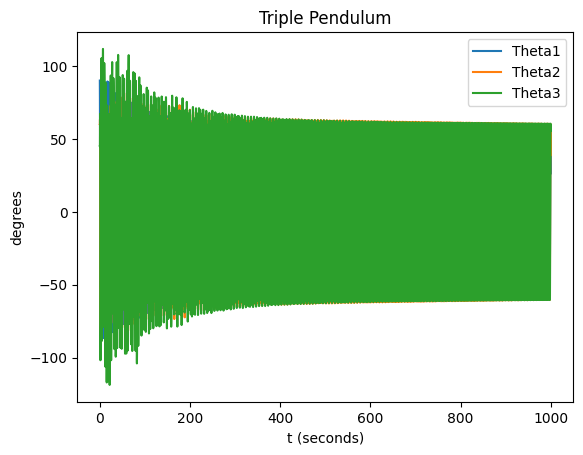

(7960, 150)
(7960, 3)
(1990, 150)
(1990, 3)


In [3]:
from __future__ import division, print_function
from math import sin, cos, pi
import numpy as np
from pylab import plot, xlabel, ylabel, show
import matplotlib.pyplot as plt
from numpy import array, arange, zeros_like
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import pdb

g = 9.81
l1 = 1
l2 = 1
l3= 1
m1 = 1.0
m2 = 1.0
m3 = 1.0

def f(q, t):
    '''Triple Pendulum equation of motion'''

    # Define relevant parameters

    # Define useful mass combinations
    m12 = m2 + m3
    m012 = m1 + m2 + m3
    mf = m012/4

    # Define useful sines
    sin0 = np.sin(q[0])
    sin1 = np.sin(q[2])
    sin2 = np.sin(q[4])

    # Define useful sine and cosine of differences
    cos01 = np.cos(q[0]-q[2])
    cos02 = np.cos(q[0]-q[4])
    cos12 = np.cos(q[2]-q[4])
    sin01 = np.sin(q[0]-q[2])
    sin02 = np.sin(q[0]-q[4])
    sin12 = np.sin(q[2]-q[4])

    # Define useful recurrent patterns
    r1 = m12*cos01*cos02 - m012*cos12
    r2 = m012 - m12*(cos01)**2
    r3 = -m012 + m3*(cos02)**2

    # Define parts of the first equation
    od1_1 = 4*m3*m12
    od1_2 = r1*cos01 + r2*cos02
    od1_3 = -g*sin2 + l1*sin02*q[1]**2 + l2*sin12*q[3]**2
    od1_4 = -g*m2*sin1 - g*m3*sin1 + l1*m2*sin01*q[1]**2 + l1*m3*sin01*q[1]**2 - l3*m3*sin12*q[5]**2
    od1_5 = -m3*m12*( -cos02 + np.cos(q[0]-2*q[2]+q[4]) )**2 * m012
    od1_6 = g*m1*sin0 + g*m2*sin0 + g*m3*sin0 + l2*m2*sin01*q[3]**2 + l2*m3*sin01*q[3]**2 + l3*m3*sin02*q[5]**2
    od1_7 = m3*r1**2 + m12*r3*r2

    # Define parts of the second equation
    od2_1 = -g*sin2 + l1*sin02*q[1]**2 + l2*sin12*q[3]**2
    od2_2 = g*m1*sin0 + g*m2*sin0 + g*m3*sin0 + l2*m2*sin01*q[3]**2 + l2*m3*sin01*q[3]**2 + l3*m3*sin02*q[5]**2
    od2_3 = -g*m2*sin1 - g*m3*sin1 + l1*m2*sin01*q[1]**2 + l1*m3*sin01*q[1]**2 - l3*m3*sin12*q[5]**2

    # Define parts of the thirds equation
    od3_1 = g*m1*sin0 + g*m2*sin0 + g*m3*sin0 + l2*m2*sin01*q[3]**2 + l2*m3*sin01*q[3]**2 + l3*m3*sin02*q[5]**2
    od3_2 = -g*sin2 + l1*sin02*q[1]**2 + l2*sin12*q[3]**2
    od3_3 = g*m2*sin1 + g*m3*sin1 - l1*m2*sin01*q[1]**2 - l1*m3*sin01*q[1]**2 + l3*m3*sin12*q[5]**2

    # ThetaDot equations
    td1 = q[1]
    td2 = q[3]
    td3 = q[5]

    # OmegaDot equations
    od1 = mf * ( od1_1 * od1_2 * od1_3 * r2 - 4 * ( -m3 * od1_2 * r1 + ( m3 * r1**2 + m12 * r3 * r2 ) * cos01 ) * od1_4 - ( od1_5 + 4*m3*r1**2 + 4*m12*r3*r2 ) * od1_6 ) / ( l1 * od1_7 * m012 * r2)
    od2 = ( -m3 * r1 * m012 * od2_1 * r2 - ( m3 * ( r1*cos01 + r2*cos02 ) * r1 - ( m3*r1**2 + m12*r3*r2 ) * cos01 ) * od2_2 + m012*r3*r2*od2_3 ) / ( l2 * od1_7 * r2 )
    od3 = -( m12 * (od1_2) * (od3_1) + m12 * m012 * (od3_2) * r2 - r1*m012 * od3_3 ) / ( l3 * ( m3*r1**2 + m12*r3*r2 ) )

    return np.array([td1, od1, td2, od2, td3, od3])

a = 0.0
b = 1000
N = 10000
h = (b - a) / N

tpoints = np.arange(a, b, h)
theta1_points = np.zeros_like(tpoints)  # Preallocate arrays with zeros
theta2_points = np.zeros_like(tpoints)
theta3_points = np.zeros_like(tpoints)

q = np.array([np.pi / 2, 0, np.pi / 3, 0, np.pi / 4, 0], float)  # Initial conditions

for i, t in enumerate(tpoints):
    theta1_points[i] = q[0] * 180 / np.pi  # Convert to degrees
    theta2_points[i] = q[2] * 180 / np.pi
    theta3_points[i] = q[4] * 180 / np.pi

    k1 = h * f(q, t)
    k2 = h * f(q + 0.5 * k1, t + 0.5 * h)
    k3 = h * f(q + 0.5 * k2, t + 0.5 * h)
    k4 = h * f(q + k3, t + h)
    q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

plt.plot(tpoints, theta1_points, label='Theta1')
plt.plot(tpoints, theta2_points, label='Theta2')
plt.plot(tpoints, theta3_points, label='Theta3')
plt.title("Triple Pendulum")
xlabel("t (seconds)")
ylabel("degrees")
plt.legend()
plt.show()



data = np.stack((theta1_points, theta2_points, theta3_points), axis=1)
np.save('pendulum_data.npy', data)

data = np.load('pendulum_data.npy')

# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# create the sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 50
X, y = create_sequences(data, SEQ_LENGTH)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ntrain, nx, ny = X_train.shape
X_train_2d = X_train.reshape((ntrain,nx*ny))

mtest, mx, my = X_test.shape
X_test_2d = X_test.reshape((mtest,mx*my))

print(X_train_2d.shape)
print(y_train.shape)
print(X_test_2d.shape)
print(y_test.shape)

# Convert to PyTorch tensors
#X_train = torch.tensor(X_train, dtype=torch.float32)
#y_train = torch.tensor(y_train, dtype=torch.float32)
#X_test = torch.tensor(X_test, dtype=torch.float32)
#y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
#train_dataset = TensorDataset(X_train, y_train)
#test_dataset = TensorDataset(X_test, y_test)

#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

n_est = [10, 25, 50, 100, 200]
clfs = []
for n in n_est:
  clf = RandomForestRegressor(n_estimators=n)
  clfs.append(clf)

for clf in clfs:
  clf.fit(X_train_2d, y_train)



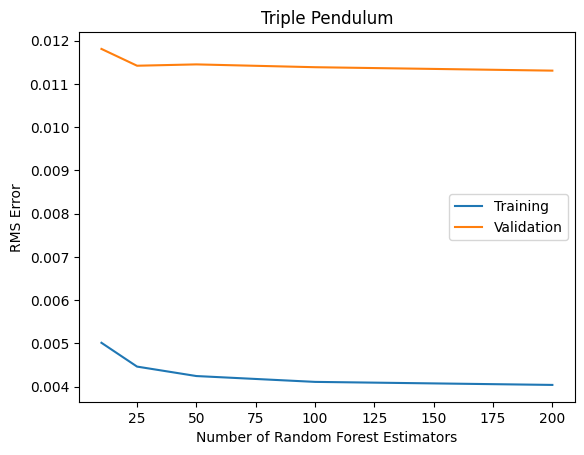

In [4]:
rmse_clfs = []
rmse_train_clfs=[]
def frmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

for clf in clfs:
  y_out = clf.predict(X_test_2d)
  y_out_train = clf.predict(X_train_2d)
  rmse = frmse(y_out, y_test)
  rmse_train = frmse(y_out_train, y_train)
  rmse_clfs.append(rmse)
  rmse_train_clfs.append(rmse_train)

#print("Predicted Values")
#print(y_out)
#print("\n Target Values")
#print(y_test)

plt.plot(n_est, rmse_train_clfs, label='Training')
plt.plot(n_est, rmse_clfs, label='Validation')
plt.title("Triple Pendulum")
xlabel("Number of Random Forest Estimators")
ylabel("RMS Error")
plt.legend()
plt.show()



In [5]:
print("Test RMSE=", rmse_clfs[3])

Test RMSE= 0.011386895200360332


In [9]:
from sklearn.metrics import r2_score
r2_test = r2_score(y_test.ravel(),y_out.ravel())
print('R-squared scores:', round(r2_test, 2))

R-squared scores: 1.0
